In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
import xgboost

In [5]:
df_train = pd.read_csv("./data/train.csv")

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104805 entries, 0 to 104804
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Id                                    104805 non-null  int64  
 1   SeriousDlqin2yrs                      104805 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  104805 non-null  float64
 3   age                                   104805 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  104805 non-null  int64  
 5   DebtRatio                             104805 non-null  float64
 6   MonthlyIncome                         84024 non-null   float64
 7   NumberOfOpenCreditLinesAndLoans       104805 non-null  int64  
 8   NumberOfTimes90DaysLate               104805 non-null  int64  
 9   NumberRealEstateLoansOrLines          104805 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  104805 non-null  int64  
 11  

In [8]:
#Imputación de NaN mediante KNN
imputer = KNNImputer(n_neighbors=3)
imputer.fit(df_train[['Id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']])

df_train[['Id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']] = imputer.transform(df_train[['Id', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents']])

<ipython-input-11-f811aa06fa37>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


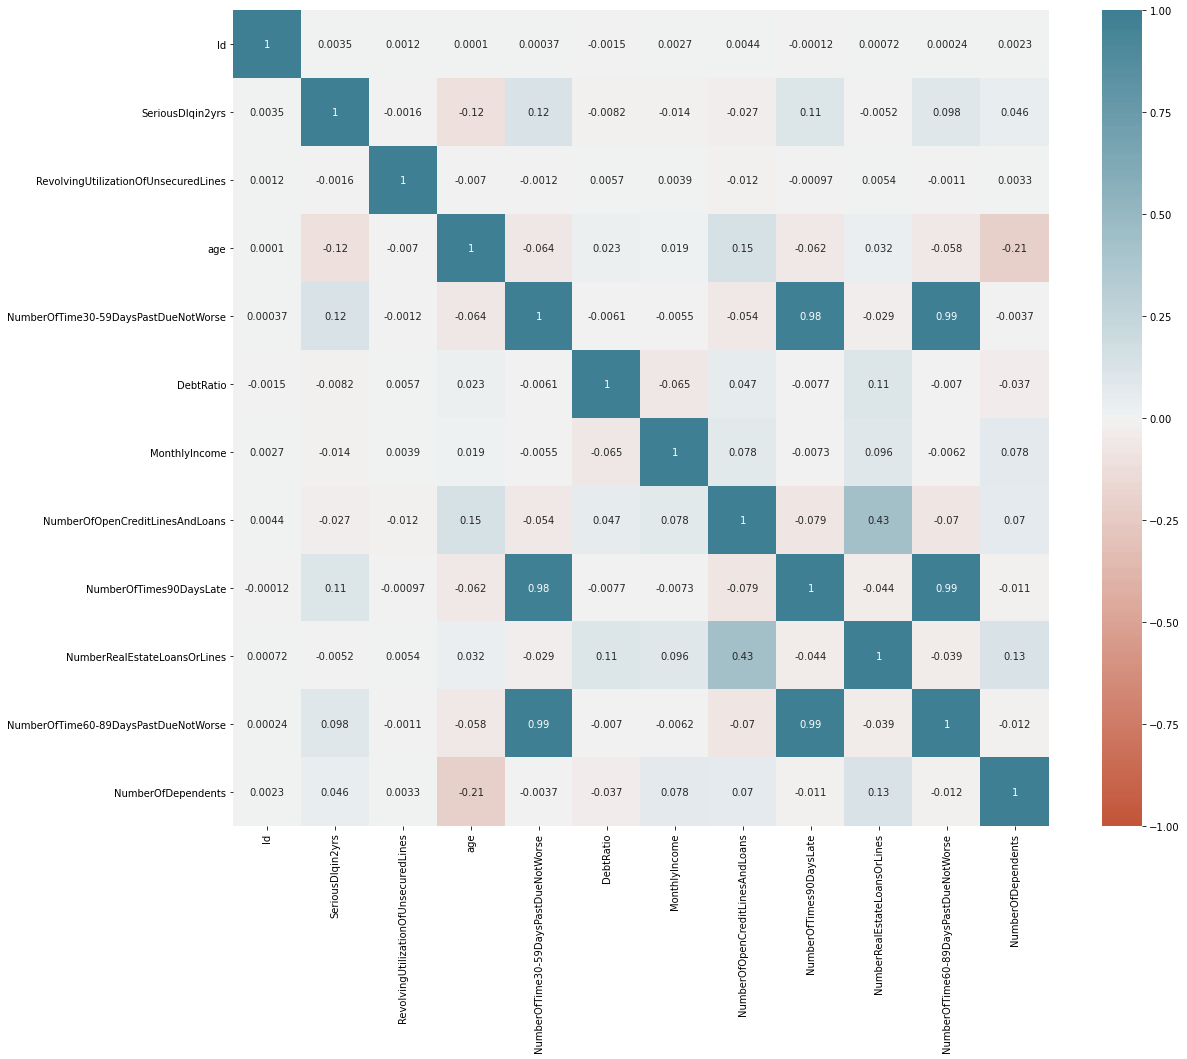

In [11]:
corr = df_train.corr()
fig = plt.figure(figsize=(19, 15))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
    
)
fig.show()

In [ ]:
X_train = df_train.drop('SeriousDlqin2yrs', axis=1)
y_train = df_train['SeriousDlqin2yrs']

In [ ]:
# XGBoost
grid_xgboost = {
                          "learning_rate": [0.05, 0.1, 0.15, 0.2, 0.25, 0.4, 0.5],  # Cuanto más alto, mas aporta cada nuevo arbol
                          
                          "n_estimators": [20,50,75,100, 150,200], # Cuidado con poner muchos estiamdores ya que vamos a
                                                           # sobreajustar el modelo
                          
                          "max_depth": [1,2,3,4,5] # No es necesario poner una profundiad muy alta. Cada nuevo
                                                    # arbol va corrigiendo el error de los anteriores.
                          
                          }


In [ ]:
xgb_clas = xgboost.XGBClassifier()

In [ ]:
model = [('grid_xgboost', xgb_clas, grid_xgboost1)]
models_gridsearch = {}

In [ ]:
for i in model:
    models_gridsearch[i[0]] = GridSearchCV(i[1],
                                          i[2],
                                          cv = 10,
                                          verbose =1,
                                          scoring = 'roc_auc',
                                          n_jobs = -1)
    
    models_gridsearch[i[0]].fit(X_train, y_train)

Fitting 10 folds for each of 45 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 39.3min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 39.9min finished


In [ ]:
best_grids = [(i, j.best_score_) for i, j in models_gridsearch.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
0,grid_xgboost,0.861767


In [ ]:
print(models_gridsearch['grid_xgboost'].best_estimator_)
print(models_gridsearch['grid_xgboost'].best_score_)
print(models_gridsearch['grid_xgboost'].best_params_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.8617673665886226
{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.8617673665886226
{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}

In [ ]:
df_test = pd.read_csv("test.csv")

In [ ]:
predictions_proba = models_gridsearch['grid_xgboost'].predict_proba(df_test)

In [ ]:
predictions_proba

array([[0.61774415, 0.38225585],
       [0.9785627 , 0.0214373 ],
       [0.98564076, 0.01435924],
       ...,
       [0.99352354, 0.00647647],
       [0.9681282 , 0.03187182],
       [0.976872  , 0.02312795]], dtype=float32)

In [ ]:
df_submission = df_test[['Id']]

df_submission['SeriousDlqin2yrs'] = predictions_proba[:,-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_submission

,Id,SeriousDlqin2yrs
0,0,0.382256
1,9,0.021437
2,17,0.014359
3,18,0.025784
4,24,0.010819
...,...,...
45190,149992,0.085288
45191,149994,0.035489
45192,149995,0.006476
45193,149996,0.031872


In [ ]:
df_submission.describe()

,Id,SeriousDlqin2yrs
count,45195.000000,45195.000000
mean,74966.545702,0.066565
std,43249.355523,0.116770
min,0.000000,0.003080
25%,37484.500000,0.011572
50%,75168.000000,0.022934
75%,112194.500000,0.065836
max,149997.000000,0.944390


In [ ]:
df_submission.to_csv('submission.csv', index=False)